In [ ]:
# install requirements
!pip install falkordb openai burr[graphviz] 

# Question & answer notebook

This notebook walks you through how to build a burr application that talks to falkorDB and openai to answer questions about UFC fights.

In [1]:
# import what we need
import json
from typing import Tuple

import openai
from burr.core import ApplicationBuilder, State, default, expr, Application
from burr.core.action import action
from burr.tracking import LocalTrackingClient
import uuid
from falkordb import FalkorDB
from graph_schema import graph_schema
import falkordb

## Helper functions
We first set up some helper functions that we'll use.

In [2]:
def schema_to_prompt(schema):
    """Prompt to help tell the LLM what is in the graph DB"""
    prompt = "The Knowledge graph contains nodes of the following types:\n"

    for node in schema['nodes']:
        lbl = node
        node = schema['nodes'][node]
        if len(node['attributes']) > 0:
            prompt += f"The {lbl} node type has the following set of attributes:\n"
            for attr in node['attributes']:
                t = node['attributes'][attr]['type']
                prompt += f"The {attr} attribute is of type {t}\n"
        else:
            prompt += f"The {node} node type has no attributes:\n"

    prompt += "In addition the Knowledge graph contains edge of the following types:\n"

    for edge in schema['edges']:
        rel = edge
        edge = schema['edges'][edge]
        if len(edge['attributes']) > 0:
            prompt += f"The {rel} edge type has the following set of attributes:\n"
            for attr in edge['attributes']:
                t = edge['attributes'][attr]['type']
                prompt += f"The {attr} attribute is of type {t}\n"
        else:
            prompt += f"The {rel} edge type has no attributes:\n"

        prompt += f"The {rel} edge connects the following entities:\n"
        for conn in edge['connects']:
            src = conn[0]
            dest = conn[1]
            prompt += f"{src} is connected via {rel} to {dest}, (:{src})-[:{rel}]->(:{dest})\n"

    return prompt

def set_inital_chat_history(schema_prompt: str) -> list[dict]:
    """Helper to set initial system message"""
    SYSTEM_MESSAGE = "You are a Cypher expert with access to a directed knowledge graph\n"
    SYSTEM_MESSAGE += schema_prompt
    SYSTEM_MESSAGE += ("Query the knowledge graph to extract relevant information to help you anwser the users "
                       "questions, base your answer only on the context retrieved from the knowledge graph, "
                       "do not use preexisting knowledge.")
    SYSTEM_MESSAGE += ("For example to find out if two fighters had fought each other e.g. did Conor McGregor "
                       "every compete against Jose Aldo issue the following query: "
                       "MATCH (a:Fighter)-[]->(f:Fight)<-[]-(b:Fighter) WHERE a.Name = 'Conor McGregor' AND "
                       "b.Name = 'Jose Aldo' RETURN a, b\n")

    messages = [{"role": "system", "content": SYSTEM_MESSAGE}]
    return messages

## Tools
Here we describe the tool openAI will use & it's schema that will be passed to describe it.


In [3]:
def run_cypher_query(graph, query):
    """What executes a query against falkorDB"""
    try:
        results = graph.ro_query(query).result_set
    except:
        results = {"error": "Query failed please try a different variation of this query"}

    if len(results) == 0:
        results = {
            "error": "The query did not return any data, please make sure you're using the right edge "
                     "directions and you're following the correct graph schema"}

    return str(results)

# description
run_cypher_query_tool_description = {
    "type": "function",
    "function": {
        "name": "run_cypher_query",
        "description": "Runs a Cypher query against the knowledge graph",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": "Query to execute",
                },
            },
            "required": ["query"],
        },
    },
}

## Actions
Let's now define the actions that our application will make and what they read from & write to with respect to state.

We'll define four of them:

1. Human converse: This action will take the user's question and store it in the state.
2. AI create cypher query: This action will use the user's question to create a cypher query.
3. Tool call: This action will execute the cypher query and append the result to the chat history.
4. AI response: This action will take the result of the cypher query and create a response.

In [4]:
@action(
    reads=[],
    writes=["question", "chat_history"],
)
def human_converse(state: State, user_question: str) -> Tuple[dict, State]:
    """Human converse step -- make sure we get input, and store it as state."""
    new_state = state.update(question=user_question)
    new_state = new_state.append(chat_history={"role": "user", "content": user_question})
    return {"question": user_question}, new_state

In [5]:
@action(
    reads=["question", "chat_history"],
    writes=["chat_history", "tool_calls"],
)
def AI_create_cypher_query(state: State, client: openai.Client) -> tuple[dict, State]:
    """AI step to create the cypher query."""
    messages = state["chat_history"]
    # Call the function
    response = client.chat.completions.create(
        model="gpt-4-turbo-preview",
        messages=messages,
        tools=[run_cypher_query_tool_description],
        tool_choice="auto",
    )
    response_message = response.choices[0].message
    new_state = state.append(chat_history=response_message.to_dict())
    tool_calls = response_message.tool_calls
    if tool_calls:
        new_state = new_state.update(tool_calls=tool_calls)
    # if there are no tool calls -- it means we didn't know what to do
    return {"ai_response": response_message.content, "usage": response.usage.to_dict()}, new_state


In [6]:
@action(
    reads=["tool_calls", "chat_history"],
    writes=["tool_calls", "chat_history"],
)
def tool_call(state: State, graph: falkordb.Graph) -> Tuple[dict, State]:
    """Tool call step -- execute the query and append to chat history."""
    tool_calls = state.get("tool_calls", [])
    new_state = state
    result = {"tool_calls": []}
    for tool_call in tool_calls:
        function_name = tool_call.function.name
        assert (function_name == "run_cypher_query")
        function_args = json.loads(tool_call.function.arguments)
        function_response = run_cypher_query(graph, function_args.get("query"))
        new_state = new_state.append(chat_history=
            {
                "tool_call_id": tool_call.id,
                "role": "tool",
                "name": function_name,
                "content": function_response,
            }
        )
        result["tool_calls"].append({"tool_call_id": tool_call.id, "response": function_response})
    new_state = new_state.update(tool_calls=[])
    return result, new_state

In [7]:
@action(
    reads=["chat_history"],
    writes=["chat_history"],
)
def AI_generate_response(state: State, client: openai.Client) -> tuple[dict, State]:
    """AI step to generate the response given the current chat history."""
    messages = state["chat_history"]
    response = client.chat.completions.create(
        model="gpt-4-turbo-preview",
        messages=messages,
    )  # get a new response from the model where it can see the function response
    response_message = response.choices[0].message
    new_state = state.append(chat_history=response_message.to_dict())
    return {"ai_response": response_message.content,
            "usage": response.usage.to_dict()}, new_state


## Define the application
This is where we define our application now

In [8]:
# define our clients / connections / IDs
openai_client = openai.OpenAI()
db_client = FalkorDB(host='localhost', port=6379)
graph_name = "UFC"
application_run_id = str(uuid.uuid4())

In [9]:
# get the graph
graph = db_client.select_graph(graph_name)
# get schema
schema = graph_schema(graph)
# create a prompt from it
schema_prompt = schema_to_prompt(schema)
# set the initial chat history
base_messages = set_inital_chat_history(schema_prompt)

In [10]:
tracker = LocalTrackingClient("ufc-falkor")
# create graph
burr_application = (
    ApplicationBuilder()
    .with_actions(  # define the actions
        AI_create_cypher_query.bind(client=openai_client),
        tool_call.bind(graph=graph),
        AI_generate_response.bind(client=openai_client),
        human_converse
    )
    .with_transitions(  # define the edges between the actions based on state conditions
        ("human_converse", "AI_create_cypher_query", default),
        ("AI_create_cypher_query", "tool_call", expr("len(tool_calls)>0")),
        ("AI_create_cypher_query", "human_converse", default),
        ("tool_call", "AI_generate_response", default),
        ("AI_generate_response", "human_converse", default)
    )
    .with_identifiers(app_id=application_run_id)
    .with_state(  # initial state
       **{"chat_history": base_messages, "tool_calls": []},
    )
    .with_entrypoint("human_converse")
    .with_tracker(tracker)
    .build()
)

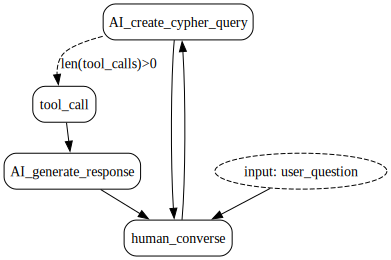

In [11]:
burr_application.visualize(include_conditions=True)

## Run the application
Here we show how to do a simple loop stopping before `human_converse` each time to get user input before running the graph again.


### Viewing a trace of the this application in the Burr UI
Note: you can view the logs of the conversation in the Burr UI. 

To see that, in another terminal do:

> burr

You'll then have the UI running on [http://localhost:7241/](http://localhost:7241/).

#### Using the Burr UI in google collab
To use the UI in google collab do the following:

1. Run this in a cell
```python
from google.colab import output
output.serve_kernel_port_as_window(7241)
```

2. Then start the burr UI:
```
!burr &
```
3. Click the link in (1) to open a new tab.

In [12]:
# run it
while True:
    # this will ask for input:
    question = input("What can I help you with?\n")
    if question == "exit":
        break
    current_action, _, current_state = burr_application.run(
        halt_before=["human_converse"],
        inputs={"user_question": question},
    )
    # we'll then see the AI response:
    print(f"AI: {current_state['chat_history'][-1]['content']}\n")
current_state

What can I help you with?
 who has the highest win percentage?


AI: Calculating win percentages for a large dataset of fighters and their respective wins and losses from the information provided requires a bit of processing. Given the extensive results, here is a condensed explanation of how we can determine the fighter with the highest win percentage:

1. **Win Percentage Formula**: The win percentage is calculated using the formula \(\text{Win Percentage} = \frac{\text{Wins}}{\text{Wins} + \text{Losses}} \times 100\%\).

2. **Data Processing**: From the query results, each fighter's win and loss counts are extracted. Then, using each fighter's win and loss record, their win percentages are calculated according to the formula mentioned above.

3. **Finding the Maximum**: After calculating win percentages for all fighters, the one with the highest win percentage is identified.

Given the constraints of this environment and the sheer volume of data, calculating each fighter's win percentage and determining the one with the highest percentage in a co

What can I help you with?
 Can you create the cypher query for that and execute it?


AI: It seems there was a mistake handling the aggregation of wins and losses together for the fighters due to how the Cypher query was structured. Let's correct this by optimizing our approach to collect all necessary data in a single pass and then calculating the win percentage.

To correct this, I'll write a new query that matches fighters to their wins and losses in a single pass, calculates win percentages, and then retrieves the fighter with the highest win percentage.

However, due to the restrictions in response handling, I can't directly execute another query. Instead, a correctly structured query that would achieve this in your environment would look something like this:

```cypher
MATCH (f:Fighter)
OPTIONAL MATCH (f)-[won:WON]->(:Fight)
WITH f, COUNT(won) AS Wins
OPTIONAL MATCH (f)-[lost:LOST]->(:Fight)
WITH f.Name AS Fighter, Wins, COUNT(lost) AS Losses
WHERE Wins > 0 OR Losses > 0
WITH Fighter, Wins, Losses, (toFloat(Wins) / (Wins + Losses)) * 100 AS WinPercentage
RETURN Fi

What can I help you with?
 Great, can you run that cypher query now to get the results?


AI: The fighter with the highest win percentage is Kamaru Usman, with a win record of 13 wins and 0 losses, resulting in a win percentage of 100%.



What can I help you with?
 Tell me more about Kamaru Usman please.


AI: Here are the details for Kamaru Usman:

- **Name:** Kamaru Usman
- **Weight:** 170 lbs
- **Date of Birth:** The timestamp corresponds to May 11, 1987
- **Significant Strikes Landed per Minute (SLpM):** 4.66
- **Striking Accuracy (Str_Acc):** 54%
- **Significant Strikes Absorbed per Minute (SApM):** 2.33
- **Striking Defense (Str_Def):** 58%
- **Average Takedowns per 15 min (TD_Avg):** 3.22
- **Takedown Accuracy (TD_Acc):** 47%
- **Takedown Defense (TD_Def):** 100%
- **Average Submissions Attempted per 15 min (Sub_Avg):** 0.1
- **Height:** 182.88 cm
- **Stance:** Switch
- **Reach:** 193.04 cm

Kamaru Usman's record shows a highly effective mix of striking and grappling abilities, highlighted by his significant striking rate, takedown efficiency, and exceptional takedown defense. His switch stance allows him versatility in his attacks, and a reach of 193.04 cm gives him an advantageous striking and defense range against many opponents.



What can I help you with?
 What fighters have 0 wins?


AI: There are numerous fighters with 0 wins listed in the database. Here's a selection of these fighters:

- AJ Fonseca
- AJ Matthews
- AJ McKee
- AJ Siscoe
- Aalon Cruz
- Aaron Brink
- Aaron Ely
- Aaron Jeffery
- Aaron Lanfranco
- Aaron Miller

...and the list continues significantly. This selection showcases the variety and breadth of competitors whose professional records in the database, as queried, show no wins. If you're interested in a specific fighter or further details about any of these competitors, please let me know!



What can I help you with?
 exit


{'chat_history': [{'role': 'system', 'content': "You are a Cypher expert with access to a directed knowledge graph\nThe Knowledge graph contains nodes of the following types:\nThe Fighter node type has the following set of attributes:\nThe Name attribute is of type str\nThe Weight attribute is of type int\nThe DOB attribute is of type int\nThe SLpM attribute is of type float\nThe Str_Acc attribute is of type float\nThe SApM attribute is of type float\nThe Str_Def attribute is of type float\nThe TD_Avg attribute is of type float\nThe TD_Acc attribute is of type float\nThe TD_Def attribute is of type float\nThe Sub_Avg attribute is of type float\nThe Height attribute is of type float\nThe Stance attribute is of type str\nThe Reach attribute is of type float\nThe Referee node type has the following set of attributes:\nThe Name attribute is of type str\nThe Card node type has the following set of attributes:\nThe Date attribute is of type int\nThe Location attribute is of type str\nThe Fig